In [671]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# Time series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import accuracy_score,classification_report

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

In [672]:
# Split data into training/validation and test sets based on dates
train_val_start_date = '2002-01-31'
test_start_date = '2018-08-31'
test_end_date = '2016-08-31'

In [673]:
stock_name = 'XRM'
file_path_1 = '/Users/edocampione/Desktop/Meng Engineering Science/4YP/data/ExxonMobil_CRSP_daily_data_alltime.csv' # Daily technical data (CRSP)

df = pd.read_csv(file_path_1)

df['date'] = pd.to_datetime(df['date'])  # CRSP daily data
df = df[(df['date'] >= train_val_start_date) & (df['date'] <= test_end_date)].copy()
df.index = range(len(df))

df.head()

PERMNO       date TICKER  BIDLO  ASKHI    PRC         VOL        RET  \
0   11850 2002-01-31    XOM  38.30  39.05  39.05  11115000.0   0.009305   
1   11850 2002-02-01    XOM  38.80  39.20  39.00   9518300.0  -0.001280   
2   11850 2002-02-04    XOM  38.26  39.20  38.35  10086100.0  -0.016667   
3   11850 2002-02-05    XOM  37.85  38.90  38.33  10948500.0  -0.000521   
4   11850 2002-02-06    XOM  38.13  38.98  38.92  10385700.0   0.015393   

   OPENPRC  
0    38.51  
1    39.15  
2    39.10  
3    38.60  
4    38.34

In [674]:
fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Ohlc(x=df.date,
                      open=df.OPENPRC,
                      high=df.ASKHI,
                      low=df.BIDLO,
                      close=df.PRC,
                      name='Price'), row=1, col=1)

fig.add_trace(go.Scatter(x=df.date, y=df.VOL, name='Volume'), row=2, col=1)

fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

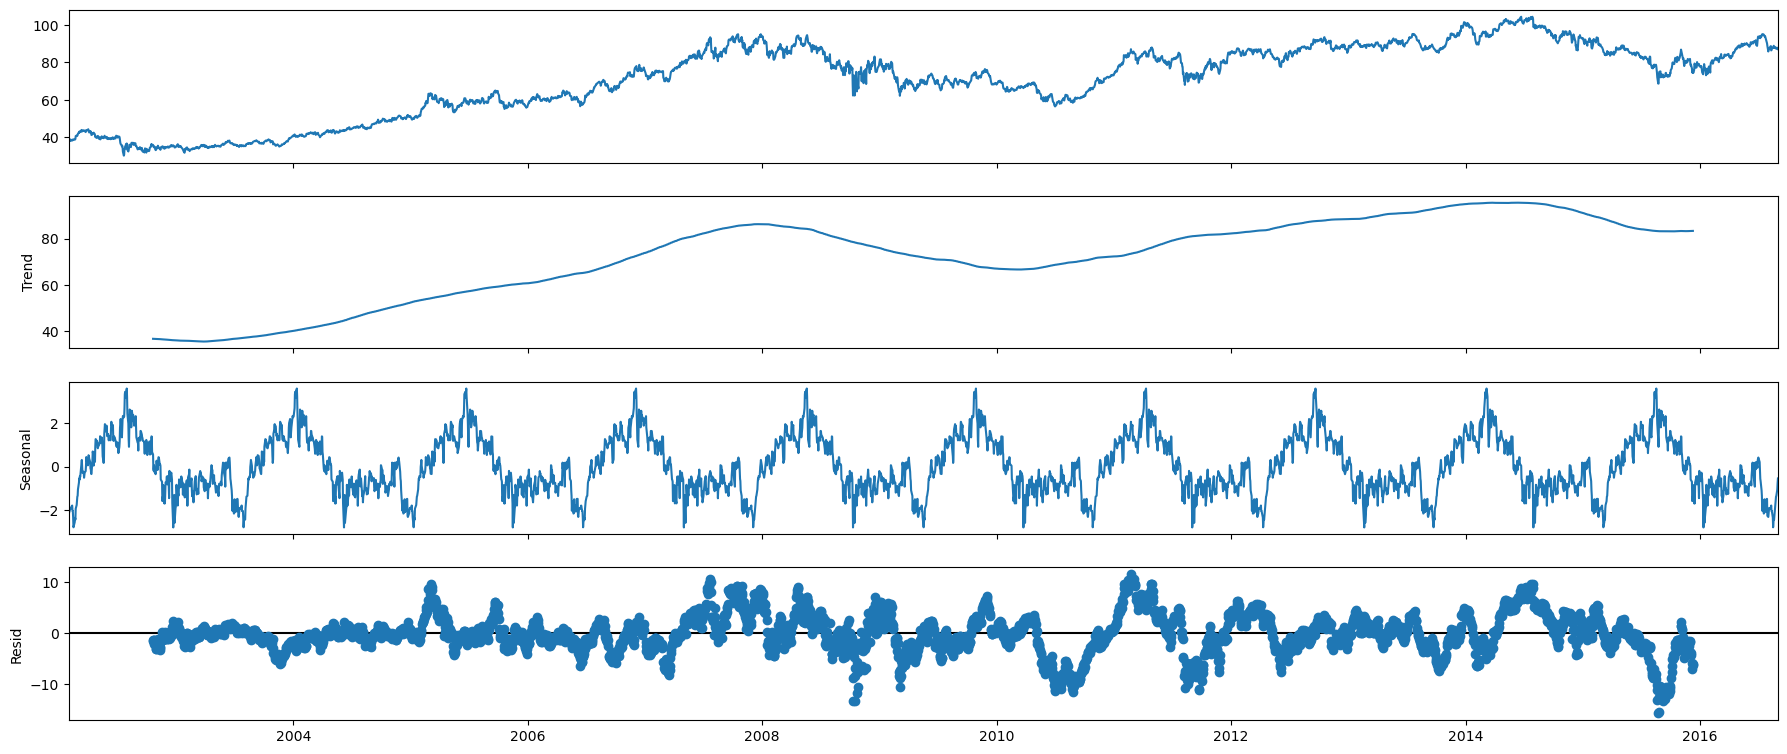

In [675]:
df_close = df[['date', 'PRC']].copy()
df_close = df_close.set_index('date')
df_close.head()

decomp = seasonal_decompose(df_close, period=365)
fig = decomp.plot()
fig.set_size_inches(20, 8)

In [676]:
df['EMA_30'] = df['PRC'].ewm(30).mean().shift()
df['SMA_5'] = df['PRC'].rolling(5).mean().shift()
df['SMA_15'] = df['PRC'].rolling(15).mean().shift()
df['SMA_30'] = df['PRC'].rolling(30).mean().shift()
df['SMA_60'] = df['PRC'].rolling(60).mean().shift()
df['SMA_90'] = df['PRC'].rolling(90).mean().shift()
df['SMA_120'] = df['PRC'].rolling(120).mean().shift()

fig = go.Figure()
fig.add_trace(go.Scatter(x=df.date, y=df.EMA_30, name='EMA 30'))
fig.add_trace(go.Scatter(x=df.date, y=df.SMA_5, name='SMA 5'))
fig.add_trace(go.Scatter(x=df.date, y=df.SMA_15, name='SMA 15'))
fig.add_trace(go.Scatter(x=df.date, y=df.SMA_30, name='SMA 30'))
fig.add_trace(go.Scatter(x=df.date, y=df.SMA_60, name='SMA 60'))
fig.add_trace(go.Scatter(x=df.date, y=df.SMA_90, name='SMA 90'))
fig.add_trace(go.Scatter(x=df.date, y=df.SMA_120, name='SMA 20'))
fig.add_trace(go.Scatter(x=df.date, y=df.PRC, name='PRC', opacity=0.2))
fig.show()

In [677]:
def relative_strength_idx(df, n=14):
    close = df['PRC']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df['RSI'] = relative_strength_idx(df).fillna(0)

fig = go.Figure(go.Scatter(x=df.date, y=df.RSI, name='RSI'))
fig.show()

In [678]:
EMA_12 = pd.Series(df['PRC'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['PRC'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.date, y=df.PRC, name='PRC'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.date, y=EMA_12, name='EMA 12'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.date, y=EMA_26, name='EMA 26'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.date, y=df['MACD'], name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter(x=df.date, y=df['MACD_signal'], name='Signal line'), row=2, col=1)
fig.show()

In [679]:
def calculate_adx(df, period=14):
    """
    Adds the ADX (Average Directional Index) column to a given DataFrame.

    Parameters:
        df (pd.DataFrame): DataFrame containing 'ASKHI', 'BIDLO', and 'PRC' columns.
        period (int): The lookback period for ADX calculation (default is 14).

    Returns:
        pd.DataFrame: DataFrame with an additional 'ADX' column (values between 0-100).
    """
    # Compute True Range (TR)
    df['High-Low'] = df['ASKHI'] - df['BIDLO']
    df['High-Close'] = abs(df['ASKHI'] - df['PRC'].shift(1))
    df['Low-Close'] = abs(df['BIDLO'] - df['PRC'].shift(1))
    df['TR'] = df[['High-Low', 'High-Close', 'Low-Close']].max(axis=1)

    # Compute Directional Movement (+DM and -DM)
    df['+DM'] = np.where((df['ASKHI'].diff() > df['BIDLO'].diff()) & (df['ASKHI'].diff() > 0), df['ASKHI'].diff(), 0)
    df['-DM'] = np.where((df['BIDLO'].diff() > df['ASKHI'].diff()) & (df['BIDLO'].diff() > 0), df['BIDLO'].diff(), 0)

    # Compute smoothed values using Wilder's smoothing (EMA-like smoothing)
    df['Smooth TR'] = df['TR'].rolling(window=period).mean()
    df['Smooth +DM'] = df['+DM'].rolling(window=period).mean()
    df['Smooth -DM'] = df['-DM'].rolling(window=period).mean()

    # Compute +DI and -DI as percentages (THIS FIXES SCALING ISSUES)
    df['+DI'] = (df['Smooth +DM'] / df['Smooth TR']) * 100
    df['-DI'] = (df['Smooth -DM'] / df['Smooth TR']) * 100

    # Compute DX (Directional Index)
    df['DX'] = (abs(df['+DI'] - df['-DI']) / (df['+DI'] + df['-DI'])) * 100

    # Compute ADX (Average of DX over the period) using Rolling Mean
    df['ADX'] = df['DX'].rolling(window=period).mean()

    # Ensure ADX is properly constrained to 0-100
    df['ADX'] = df['ADX'].clip(lower=0, upper=100)

    # Drop unnecessary intermediate columns
    df.drop(columns=['High-Low', 'High-Close', 'Low-Close', '+DM', '-DM', 'Smooth TR', 'Smooth +DM', 'Smooth -DM', 'DX'], inplace=True)

    return df

# Example Usage:
# df = pd.read_csv('your_stock_data.csv')  # Ensure your data has 'ASKHI', 'BIDLO', 'PRC' columns
# df = calculate_adx(df)


df = calculate_adx(df)

In [680]:
horizon = 30  # Prediction horizon (e.g., 1 day ahead)

# Compute Log Returns
df['log_return'] = np.log(df['PRC'].shift(-horizon)) - np.log(df['PRC'])

# Convert Log Returns into Binary Target Variable:
# 1 if price increases, 0 if price decreases or stays the same
df['target'] = (df['log_return'] > 0).astype(int)

# Drop NaNs resulting from the shift
df = df.dropna()
df.index = range(len(df))  # Reset index

# Drop log_return column if you only need the target
df = df.drop(columns=['log_return'])

df.head(10)


PERMNO       date TICKER   BIDLO   ASKHI    PRC         VOL        RET  \
0   11850 2002-07-24    XOM  30.500  34.150  33.93  39491200.0   0.097348   
1   11850 2002-07-25    XOM  33.091  34.700  33.90  26839400.0  -0.000884   
2   11850 2002-07-26    XOM  33.750  35.200  35.09  15832500.0   0.035103   
3   11850 2002-07-29    XOM  35.340  36.449  36.33  16119300.0   0.035338   
4   11850 2002-07-30    XOM  35.200  36.370  35.67  17287600.0  -0.018167   
5   11850 2002-07-31    XOM  35.250  36.880  36.76  18178800.0   0.030558   
6   11850 2002-08-01    XOM  33.510  35.790  33.65  21654000.0  -0.084603   
7   11850 2002-08-02    XOM  32.800  34.250  33.61  16048500.0  -0.001189   
8   11850 2002-08-05    XOM  32.320  34.240  32.50  12727000.0  -0.033026   
9   11850 2002-08-06    XOM  33.070  34.250  33.40  13247400.0   0.027692   

   OPENPRC     EMA_30  ...     SMA_90    SMA_120        RSI      MACD  \
0    30.90  38.589640  ...  40.232667  40.301667  30.508475 -1.986522   
1    33.94  38.436430  ...  40.125111  40.259000  27.574526 -1.898705   
2    34.00  38.287365  ...  40.015778  40.216500  33.312223 -1.713342   
3    35.90  38.182363  ...  39.919000  40.189333  39.465695 -1.449679   
4    36.37  38.121567  ...  39.839000  40.172667  41.773779 -1.279231   
5    35.52  38.041150  ...  39.751667  40.145583  48.904639 -1.044165   
6    35.25  37.999148  ...  39.677111  40.132750  42.026578 -1.096175   
7    33.85  37.856638  ...  39.574889  40.094083  43.822171 -1.127622   
8    33.65  37.717558  ...  39.462333  40.053333  42.449664 -1.227952   
9    33.15  37.546764  ...  39.335111  40.004167  43.984758 -1.220773   

   MACD_signal     TR        +DI        -DI        ADX  target  
0    -1.374934  3.650  11.408340   8.693942  49.096351       0  
1    -1.479688  1.609  11.027035  17.609035  48.795279       1  
2    -1.526419  1.450  10.634787  18.042466  48.027125       0  
3    -1.511071  1.359  10.432405  23.418951  48.762853       0  
4    -1.464703  1.170  10.985681  24.660959  49.498582       0  
5    -1.380596  1.630  12.825335  24.484730  50.749005       0  
6    -1.323711  3.250  11.948980  22.811690  51.999428       1  
7    -1.284493  1.450  12.478044  23.821721  54.077961       1  
8    -1.273185  1.920  12.253845  21.057927  51.958803       1  
9    -1.262703  1.750  12.012118  20.536847  48.958274       0  

[10 rows x 24 columns]

In [681]:
test_size  = 0.15
valid_size = 0.15

test_split_idx  = int(df.shape[0] * (1-test_size))
valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))

train_df  = df.loc[:valid_split_idx].copy()
valid_df  = df.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = df.loc[test_split_idx+1:].copy()

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.date, y=train_df.PRC, name='Training'))
fig.add_trace(go.Scatter(x=valid_df.date, y=valid_df.PRC, name='Validation'))
fig.add_trace(go.Scatter(x=test_df.date,  y=test_df.PRC,  name='Test'))
fig.show()

test_prices = test_df['PRC']

In [682]:
test_df.head()

PERMNO       date TICKER   BIDLO   ASKHI     PRC         VOL        RET  \
2995   11850 2014-06-17    XOM  101.45  102.59  102.42   9355388.0  -0.004858   
2996   11850 2014-06-18    XOM  102.06  102.95  102.73   9575877.0   0.003027   
2997   11850 2014-06-19    XOM  101.68  102.84  102.63  11107691.0  -0.000973   
2998   11850 2014-06-20    XOM  102.94  104.06  103.83  17681113.0   0.011693   
2999   11850 2014-06-23    XOM  103.88  104.61  104.38   8553670.0   0.005297   

      OPENPRC      EMA_30  ...     SMA_90    SMA_120        RSI      MACD  \
2995   102.58   99.967766  ...  97.995556  97.887417  60.334347  0.438370   
2996   102.57  100.046870  ...  98.135778  97.920000  60.928144  0.479093   
2997   102.61  100.133423  ...  98.270778  97.949250  67.384106  0.497562   
2998   103.28  100.213958  ...  98.416444  97.963667  79.248120  0.602089   
2999   104.11  100.330604  ...  98.560778  97.983000  79.555556  0.720996   

      MACD_signal    TR        +DI        -DI        ADX  target  
2995     0.297912  1.47  21.222032   7.251993  24.126860       1  
2996     0.334148  0.89  20.836853  11.378629  25.732146       0  
2997     0.366831  1.16  20.465406  11.175789  27.337432       0  
2998     0.413883  1.43  20.161296  19.520300  27.311752       0  
2999     0.475305  0.78  20.606692  26.440963  26.781005       0  

[5 rows x 24 columns]

In [683]:
drop_cols = ['date', 'VOL', 'BIDLO', 'ASKHI', 'RET', 'OPENPRC', 'TICKER', 'PERMNO','PRC']

train_df = train_df.drop(drop_cols, 1)
valid_df = valid_df.drop(drop_cols, 1)
test_df  = test_df.drop(drop_cols, 1)

In [684]:
y_train = train_df['target'].copy()
X_train = train_df.drop(['target',], 1)

y_valid = valid_df['target'].copy()
X_valid = valid_df.drop(['target',], 1)

y_test  = test_df['target'].copy()
X_test  = test_df.drop(['target',], 1)

test_df.head()

EMA_30    SMA_5      SMA_15      SMA_30      SMA_60     SMA_90  \
2995   99.967766  102.128  101.260000  101.555000  100.007167  97.995556   
2996  100.046870  102.320  101.330667  101.538667  100.142333  98.135778   
2997  100.133423  102.476  101.442000  101.540667  100.277167  98.270778   
2998  100.213958  102.670  101.532667  101.524667  100.405833  98.416444   
2999  100.330604  102.906  101.752667  101.575000  100.558000  98.560778   

        SMA_120        RSI      MACD  MACD_signal    TR        +DI        -DI  \
2995  97.887417  60.334347  0.438370     0.297912  1.47  21.222032   7.251993   
2996  97.920000  60.928144  0.479093     0.334148  0.89  20.836853  11.378629   
2997  97.949250  67.384106  0.497562     0.366831  1.16  20.465406  11.175789   
2998  97.963667  79.248120  0.602089     0.413883  1.43  20.161296  19.520300   
2999  97.983000  79.555556  0.720996     0.475305  0.78  20.606692  26.440963   

            ADX  target  
2995  24.126860       1  
2996  25.732146       0  
2997  27.337432       0  
2998  27.311752       0  
2999  26.781005       0

In [685]:


%%time

parameters = {
    'n_estimators': [300],
    'learning_rate': [0.05],
    'max_depth': [8],
    'gamma': [0.00001],
    'random_state': [42]
}

eval_set = [(X_train, y_train), (X_valid, y_valid)]
model = xgb.XGBClassifier(eval_set=eval_set, objective='binary:logistic', verbose=False)
clf = GridSearchCV(model, parameters)

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')



/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[19:09:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[19:09:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[19:09:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[19:09:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[19:09:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { 

Best params: {'gamma': 1e-05, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 300, 'random_state': 42}
Best validation score = 0.40731783429552193
CPU times: user 35.9 s, sys: 2.31 s, total: 38.2 s
Wall time: 8.8 s


In [686]:
%%time

model = xgb.XGBClassifier(**clf.best_params_, objective='binary:logistic')
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

CPU times: user 5.45 s, sys: 140 ms, total: 5.59 s
Wall time: 764 ms


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1e-05, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

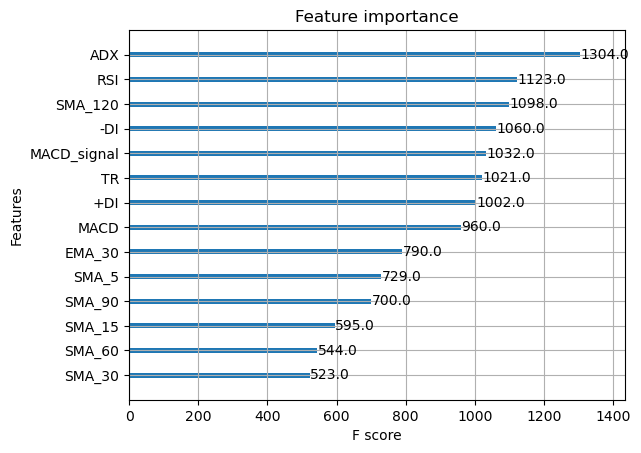

In [687]:
plot_importance(model);

In [688]:
y_pred = model.predict(X_test)

print(f'y_true = {np.array(y_test)[:10]}')
print(f'y_pred = {y_pred[:10]}')

Accuracy = accuracy_score(y_test, y_pred)
print(Accuracy)

# Classification report
classification_report_data = classification_report(y_test, y_pred)
# Print the classification report
print(classification_report_data)

#test_df.head()

# Convert predicted log returns to prices
#y_pred_price = test_prices.values * np.exp(y_pred)  # Apply transformation
#y_test_price = test_prices.values * np.exp(y_test)

#print(f'y_true_price = {np.array(y_test_price)[:5]}')
#print(f'y_pred_price = {y_pred_price[:5]}')

y_true = [1 0 0 0 0 0 0 0 0 0]
y_pred = [0 0 0 0 0 0 0 0 0 0]
0.7310606060606061
              precision    recall  f1-score   support

           0       0.73      0.83      0.78       302
           1       0.73      0.59      0.65       226

    accuracy                           0.73       528
   macro avg       0.73      0.71      0.72       528
weighted avg       0.73      0.73      0.73       528

